In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../dataset/names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3 # context length, how many characters to take to predict next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0 for _ in range(block_size)]
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [5]:
#MLP
n_embd = 10 # the dimensions of character embedding vectors
n_hidden = 200 # number of neuron in hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                   generator=g) * (5/3)/((n_embd * block_size) ** 0.5) # embedding vector (ex: 27 * 2)
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * 0.2 # block size * dimensions of embedding vector (2 * 3 x 200)
b1 = torch.randn(n_hidden,                              generator=g) * 0.01 # 200
W2 = torch.randn((n_hidden, vocab_size),                generator=g) * 0.01# 200 x 27
b2 = torch.randn(vocab_size,                            generator=g)  * 0 # 27

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) #number of parameters
for p in parameters:
    p.requires_grad = True

12297


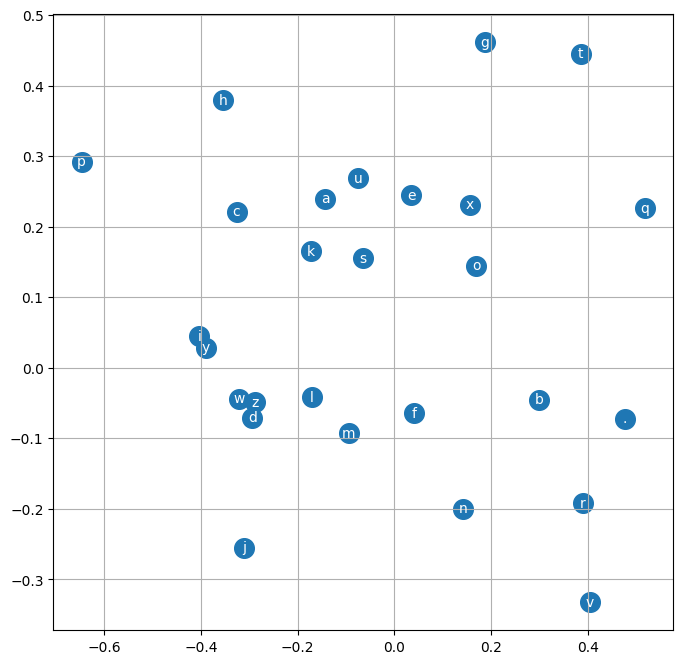

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1] .data, s=200) 
for i in range(C.shape [0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white') 
plt.grid('minor')

In [7]:
lri = []
lossi = []
stepi = []

In [8]:
hpreact.mean(0, keepdim=True).shape

NameError: name 'hpreact' is not defined

In [ ]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    #mini batch
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    # Batch Norm layer ----------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) /  bnstdi + bnbias # batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    # ------------------------------------------------
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer    
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay

    for p in parameters:
        p.data  += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break





      0/ 200000: 3.3147
  10000/ 200000: 2.1268
  20000/ 200000: 2.4243
  30000/ 200000: 2.5032
  40000/ 200000: 1.9587
  50000/ 200000: 2.3697
  60000/ 200000: 2.4918
  70000/ 200000: 2.1317
  80000/ 200000: 2.2412
  90000/ 200000: 2.1237
 100000/ 200000: 1.8426
 110000/ 200000: 2.2398
 120000/ 200000: 2.0358
 130000/ 200000: 2.5364
 140000/ 200000: 2.2967
 150000/ 200000: 2.2226
 160000/ 200000: 1.8898
 170000/ 200000: 1.8221
 180000/ 200000: 2.0714
 190000/ 200000: 1.9370


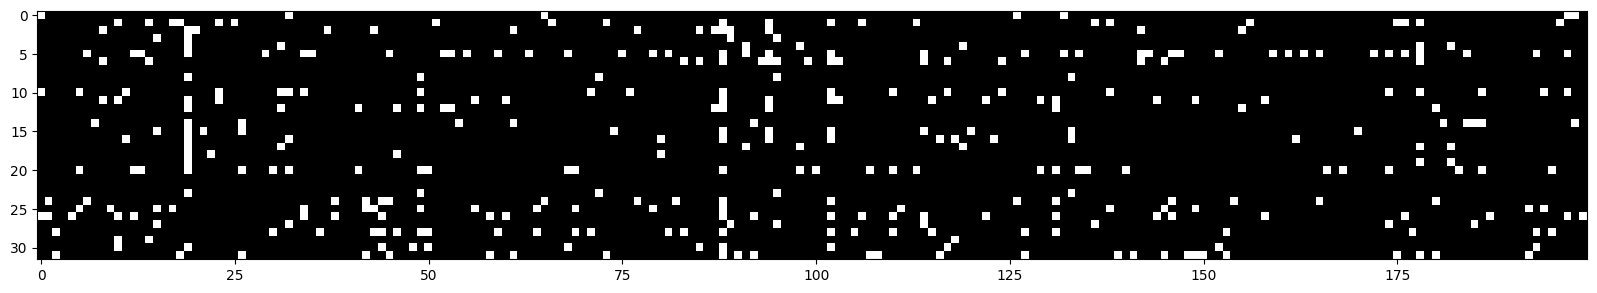

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([490., 226., 168., 140., 130., 133., 117.,  97.,  99., 106.,  97.,
        108.,  96.,  87., 110.,  89., 102.,  86.,  94.,  87.,  97., 133.,
        104., 128.,  95., 110., 102., 124.,  86., 134.,  95.,  89., 103.,
        102.,  93.,  69., 104.,  83., 112., 112., 122., 108., 111., 134.,
        103., 107., 143., 176., 228., 431.]),
 array([-9.99965847e-01, -9.59966587e-01, -9.19967327e-01, -8.79968067e-01,
        -8.39968808e-01, -7.99969548e-01, -7.59970288e-01, -7.19971029e-01,
        -6.79971769e-01, -6.39972509e-01, -5.99973249e-01, -5.59973990e-01,
        -5.19974730e-01, -4.79975470e-01, -4.39976211e-01, -3.99976951e-01,
        -3.59977691e-01, -3.19978431e-01, -2.79979172e-01, -2.39979912e-01,
        -1.99980652e-01, -1.59981393e-01, -1.19982133e-01, -7.99828732e-02,
        -3.99836135e-02,  1.56462193e-05,  4.00149059e-02,  8.00141656e-02,
         1.20013425e-01,  1.60012685e-01,  2.00011945e-01,  2.40011204e-01,
         2.80010464e-01,  3.20009724e-01,  3.60008

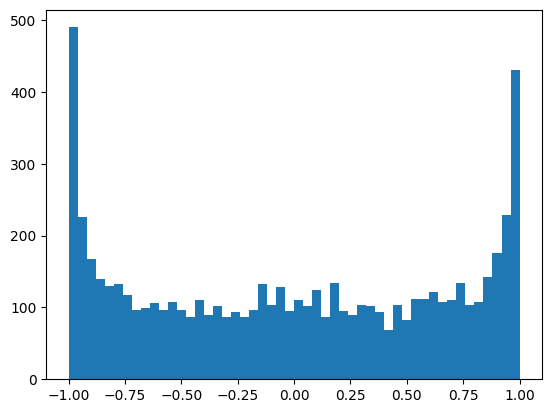

In [ ]:
plt.hist(h.view(-1).tolist(), 50)


In [ ]:
logits[0]

tensor([-3.1956,  1.4861, -0.1141, -0.2630,  0.2820,  1.6219, -1.6306, -1.1946,
         0.0411,  2.4573, -2.2893, -0.8587,  2.5442,  1.0881,  3.6777,  0.7311,
        -0.5243, -2.9656,  1.8934,  1.8522,  0.4219, -1.9445,  0.1443, -2.1349,
        -2.1959,  2.7977, -1.1107], grad_fn=<SelectBackward0>)

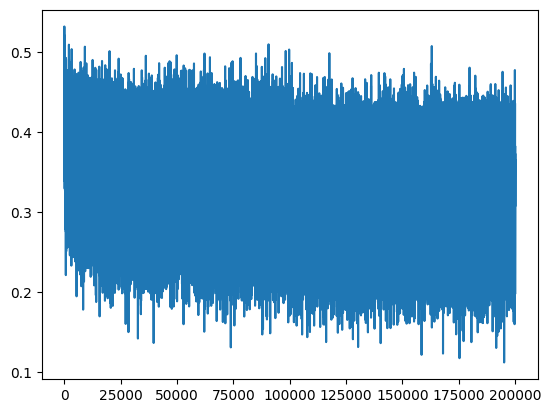

In [ ]:
# print(loss.item())
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running  + bnbias # batch normalization
    h = torch.tanh(embcat @ W1 + b1) # (N , n_hidden)
    logits = h @ W2 + b2 # (N, vocabsize)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.7793045043945312
val 2.8214025497436523


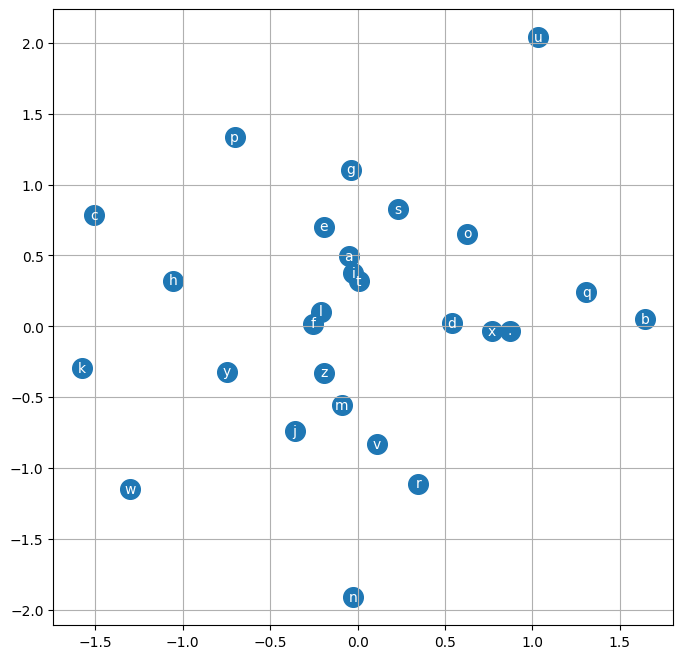

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1] .data, s=200) 
for i in range(C.shape [0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white') 
plt.grid('minor')

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
    # forward pass the neural net
        emb = C[torch. tensor ( [context])] # (1,block_size, n_embd)
        h = torch. tanh(emb. view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F. softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial (probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context [1:] + [ix]
        out.append(ix)
        # if we sample the special ',' token, break
        if ix == 0:
            break
print(''.join(itos[i] for i in out)) # decode and print the generated word

norditollyssmyesmahiictys.
